In [1]:
%load_ext autoreload
%autoreload 2
from configs import project_config
import pickle
import numpy as np
import torch
import os
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
import matplotlib.pyplot as plt
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalLSTMTSPostMeanScoreMatching import \
    ConditionalLSTMTSPostMeanScoreMatching
from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data_StbleTgt_WRMSE import get_config

In [2]:
config = get_config()
print(config.beta_min)
if config.has_cuda:
    device = int(os.environ["LOCAL_RANK"])
else:
    print("Using CPU\n")
    device = torch.device("cpu")

diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)

max_diff_steps = config.max_diff_steps
sample_eps = config.sample_eps
ts_step = config.deltaT

0.0
Using CPU



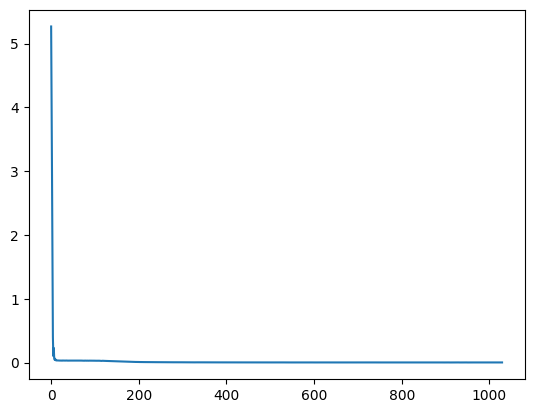

In [3]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = (np.array(pickle.load(f)).astype(float))
Nepochs_losses = np.arange(losses.shape[0])
plt.plot(Nepochs_losses, losses)

In [4]:
PM = ConditionalLSTMTSPostMeanScoreMatching(*config.model_parameters)
PM.load_state_dict(torch.load(config.scoreNet_trained_path + "_NEp" + str(960)))

<All keys matched successfully>

In [5]:
data = torch.tensor(np.load(config.data_path, allow_pickle=True), dtype=torch.float32)[:100, :]

In [6]:
data.shape

torch.Size([1000, 256])

In [7]:
PM.eval()
with torch.no_grad():
    feats, _ = PM.rnn.forward(data.unsqueeze(-1), None)

In [14]:
data = data.reshape(-1, 1)
feats = feats.reshape(-1, feats.shape[-1])

torch.Size([256000, 1])
torch.Size([256000, 20])


In [ ]:
# Example: Compute Euclidean norm of the differences along the last dimension:
pairwise_norm = torch.norm(feats.unsqueeze(1) - feats.unsqueeze(0), dim=-1)

In [ ]:
pairwise_norm.shape